**LSTM Baseline**

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
# Definitions and Constants
FILEPATH = '/content/sample_data/230401_250108_PT1H_Solcast_reduced_features.csv'
SEQUENCE_LENGTH = 24  # Use the past 12, 24, 48, 96 time steps for prediction
HIDDEN_SIZE = 64  # Number of hidden units -> # of neurons in the LSTM's hidden layer
NUM_LAYERS = 2  # Number of LSTM layers -> # of stacked LSTM layers
OUTPUT_SIZE = 12 # Predicting a single value -> 'dc_power'
LR = 0.001
NUM_EPOCHS = 25

In [ ]:
# Helpers
def file_name_no_extension(filepath):
  # Extract the filename without the folder path
  filename_with_extension = os.path.basename(filepath)

  # Remove the `.csv` extension
  filename_without_extension = os.path.splitext(filename_with_extension)[0]

  return filename_without_extension


In [ ]:
# Step 1: Load and preprocess the data
def load_data(filepath):
    data = pd.read_csv(filepath, index_col=0, parse_dates=True)
    #data = pd.read_csv(filepath)
    #data['date'] = pd.to_datetime(data['date'])  # Convert date to datetime format
    return data

In [ ]:
data = load_data(FILEPATH)

In [ ]:
# Step 2: Feature Scaling
# Separate features and target
target_column = 'dc_power'
features = [
    'air_temp', 'albedo', 'azimuth', 'clearsky_dhi', 'clearsky_dni', 'clearsky_ghi', 'clearsky_gti',
    'cloud_opacity', 'dewpoint_temp', 'dhi', 'dni', 'ghi', 'gti', 'precipitable_water',
    'precipitation_rate', 'relative_humidity', 'surface_pressure', 'snow_depth',
    'snow_water_equivalent', 'snow_soiling_rooftop', 'snow_soiling_ground',
    'wind_direction_100m', 'wind_direction_10m', 'wind_speed_100m', 'wind_speed_10m', 'zenith'
]
features = [
    'air_temp', 'azimuth', 'cloud_opacity', 'dhi', 'dni', 'ghi', 'zenith'
]
X = data[features]
y = data[target_column]

# Standardize the features
scaler = StandardScaler()
#scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert target to a numpy array
y = y.to_numpy()

In [ ]:
features

['air_temp', 'azimuth', 'cloud_opacity', 'dhi', 'dni', 'ghi', 'zenith']

In [ ]:
# Step 3: Create sequences for time-series prediction
def create_sequences(features, target, sequence_length, output_size):
    X_seq, y_seq = [], []
    for i in range(len(features) - sequence_length - output_size + 1):
        X_seq.append(features[i:i+sequence_length])  # Past `sequence_length` values
        y_seq.append(target[i+sequence_length:i+sequence_length+output_size])  # Next `output_size` values
    return np.array(X_seq), np.array(y_seq)

In [ ]:
X_seq, y_seq = create_sequences(X_scaled, y, SEQUENCE_LENGTH, OUTPUT_SIZE)

In [ ]:
y_seq.shape

(15337, 192)

In [ ]:
# Step 4: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([12413, 24, 7])
torch.Size([12413, 12])
torch.Size([3104, 24, 7])
torch.Size([3104, 12])


In [ ]:
# Step 5: Create DataLoader for batch processing
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Step 6: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])  # Use the last hidden state
        return out

In [ ]:
input_size = X_train.shape[2]  # Number of features -> 7 eg. 'air_temp', 'albedo', etc.

model = LSTMModel(input_size, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)

In [ ]:
input_size

7

In [ ]:
# Step 7: Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), LR)

In [ ]:
# Step 8: Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}')
    return epoch_loss/len(train_loader)

In [ ]:
LOSS = train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS)

Epoch 1/25, Loss: 6.1238
Epoch 2/25, Loss: 3.3465
Epoch 3/25, Loss: 2.8547
Epoch 4/25, Loss: 2.4529
Epoch 5/25, Loss: 2.2579
Epoch 6/25, Loss: 2.1942
Epoch 7/25, Loss: 2.1537
Epoch 8/25, Loss: 2.1189
Epoch 9/25, Loss: 2.0904
Epoch 10/25, Loss: 2.0665
Epoch 11/25, Loss: 2.0463
Epoch 12/25, Loss: 2.0279
Epoch 13/25, Loss: 2.0100
Epoch 14/25, Loss: 1.9911
Epoch 15/25, Loss: 1.9702
Epoch 16/25, Loss: 1.9477
Epoch 17/25, Loss: 1.9238
Epoch 18/25, Loss: 1.9000
Epoch 19/25, Loss: 1.8779
Epoch 20/25, Loss: 1.8574
Epoch 21/25, Loss: 1.8384
Epoch 22/25, Loss: 1.8209
Epoch 23/25, Loss: 1.8051
Epoch 24/25, Loss: 1.7905
Epoch 25/25, Loss: 1.7768


In [ ]:
def get_test_index_from_hour(hour=8, original_df, train_ratio=0.8):
    """
    Finds the first available testdata tensor index that matches the given hour.

    Parameters:
    - hour (int): The desired hour (0-23).
    - original_df (pd.DataFrame): The original dataset with a datetime index.
    - train_ratio (float): The fraction of data used for training (default: 0.8).

    Returns:
    - test_index (int): The index relative to testdata tensor.
    - timestamp (str): The corresponding datetime string.
    """
    # Ensure datetime format
    original_df.index = pd.to_datetime(original_df.index)

    # Compute the starting index of the test dataset
    train_size = int(len(original_df) * train_ratio)

    # Extract test dataset portion
    test_df = original_df.iloc[train_size:]  # This contains only the test set

    # Find the first row where the hour matches
    for i, timestamp in enumerate(test_df.index):
        if timestamp.hour == hour:
            test_index = i  # Relative index in testdata tensor
            return test_index, timestamp.strftime('%Y-%m-%d %H:%M:%S')

    raise ValueError(f"No test data found at hour {hour}:00.")

In [ ]:
index, timestamp = get_test_index_from_hour(hour=8, original_df=data)
print(index)
print(timestamp)

22
2024-09-01 08:00:00


In [ ]:
# Step 9: Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predictions.extend(outputs.tolist())
            actuals.extend(y_batch.tolist())
    # Feature added here!!!
    # Truncate negative predictions to 0
    predictions = np.maximum(predictions, 0)
    return np.array(predictions), np.array(actuals)

In [ ]:
predictions, actuals = evaluate_model(model, test_loader)

In [ ]:
predictions

array([[0.17377973, 0.18999034, 0.43069902, ..., 8.03505898, 7.59837818,
        6.54658079],
       [0.1769377 , 0.32707614, 1.26055872, ..., 7.5585804 , 6.37124538,
        4.24962378],
       [0.44112957, 1.43732977, 3.7953527 , ..., 6.78001928, 4.78432846,
        2.34948277],
       ...,
       [2.99710107, 3.58925247, 4.15852976, ..., 0.31067282, 0.        ,
        0.        ],
       [4.0649209 , 4.92073202, 5.14235449, ..., 0.05818707, 0.02340218,
        0.        ],
       [3.11273003, 2.3247962 , 2.29693127, ..., 0.05753306, 0.10224584,
        0.04580164]])

In [ ]:
predictions.shape

(3104, 12)

In [ ]:
len(predictions)

3068

In [ ]:
actuals.shape

NameError: name 'actuals' is not defined

In [ ]:
actuals

array([[0.        , 0.        , 0.2       , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.2       , 0.30000001, ..., 0.        , 0.        ,
        0.        ],
       [0.2       , 0.30000001, 0.60000002, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# Calculate timestamp for Test Data starting point
timestamp_test_data = data[len(X_train)+1:].iloc[:1].index.item()
TEST_DATA_START_DATETIME = timestamp_test_data.strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
# Step 10: Save the model
torch.save(model.state_dict(), 'lstm_solar_power_model.pth')

In [ ]:
# # Calculate metrics

def smape(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE).
    y_true: array-like, actual values
    y_pred: array-like, predicted values
    """
    epsilon = 1e-10  # Small constant to avoid division by zero
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_values = np.abs(y_true - y_pred) / (denominator + epsilon)
    smape_values = np.nan_to_num(smape_values, nan=0.0, posinf=0.0, neginf=0.0)  # Handle division by zero
    return np.mean(smape_values) * 100  # Convert to percentage


RMSE = np.sqrt(np.mean((predictions - actuals)**2))
MAE = mean_absolute_error(actuals, predictions)
#MAPE = np.mean(np.abs((actuals - predictions) / actuals)) * 100
R2 = r2_score(actuals, predictions)
SMAPE = smape(actuals, predictions)

# Print metrics
print(f"RMSE: {RMSE:.4f}")
print(f"MAE: {MAE:.4f}")
#print(f"MAPE: {MAPE:.2f}%")
print(f"SMAPE: {SMAPE:.2f}%")
print(f"R^2: {R2:.4f}")

RMSE: 1.2001
MAE: 0.7155
SMAPE: 120.62%
R^2: 0.4874


<ipython-input-94-f98360a3b655>:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


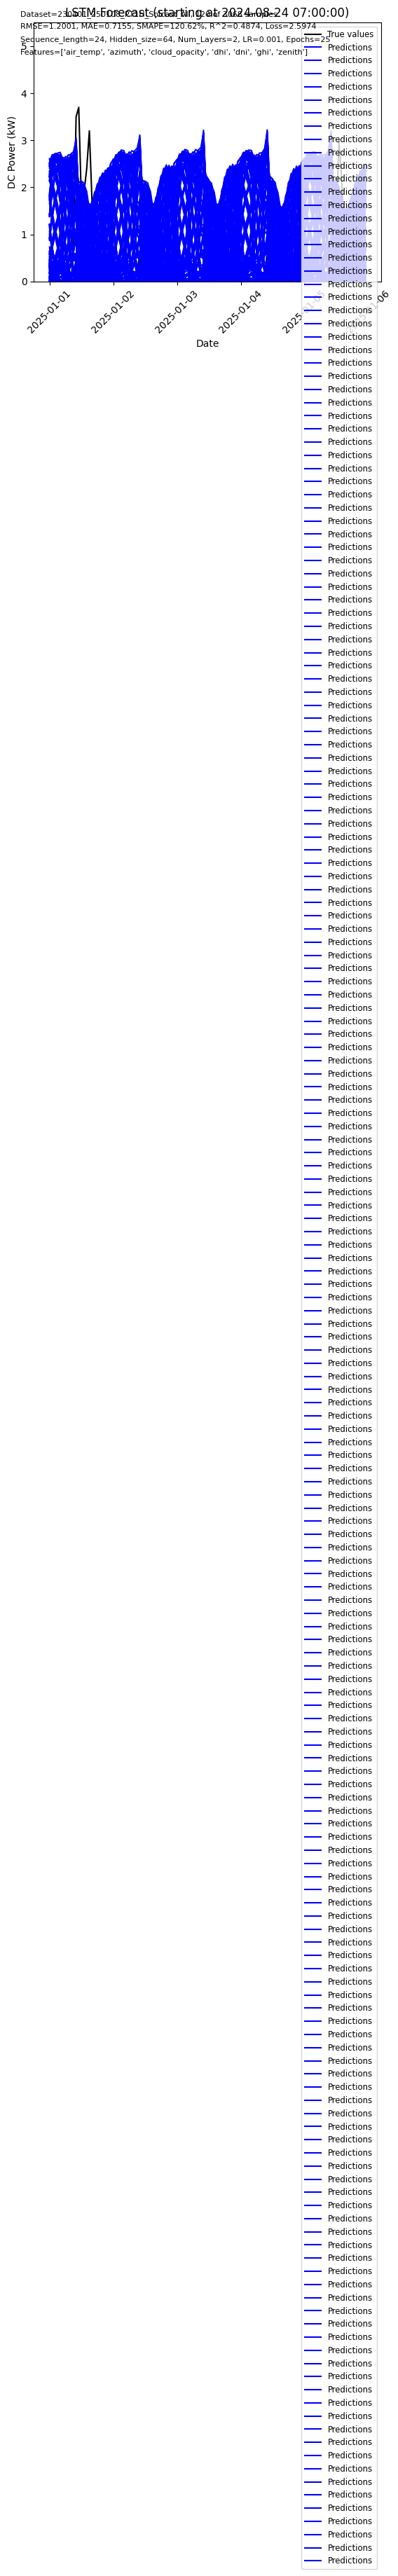

In [ ]:
# Step 11: Visualize predictions first plot
start_date = "2025-01-01"
nb_samples = 120 # 10 days if PT1H frequency

# Plot filtered data
plt.plot(data[start_date:]["dc_power"].iloc[:nb_samples], color="black", label="True values")
plt.plot(data[start_date:].iloc[:nb_samples].index, predictions[len(predictions)-len(data[start_date:].iloc[:nb_samples]):], color="blue", label="Predictions")
plt.legend(loc="upper right", fontsize="small")
plt.ylabel("DC Power (kW)")
plt.xlabel("Date")
plt.title(f"LSTM Forecast (starting at {TEST_DATA_START_DATETIME})")
plt.figtext(0.095, 0.9,f"Dataset={file_name_no_extension(FILEPATH)}, {nb_samples} of {len(X_test)} samples", fontsize=8, color='black')
plt.figtext(0.095, 0.8625,f"RMSE={RMSE:.4f}, MAE={MAE:.4f}, SMAPE={SMAPE:.2f}%, R^2={R2:.4f}, Loss={LOSS:.4f}", fontsize=8, color='black')
plt.figtext(0.095, 0.8250,f"Sequence_length={SEQUENCE_LENGTH}, Hidden_size={HIDDEN_SIZE}, Num_Layers={NUM_LAYERS}, LR={LR}, Epochs={NUM_EPOCHS}", fontsize=8, color='black')
plt.figtext(0.095, 0.7875,f"Features={features}", fontsize=8, color='black')

# Set y-axis limits
plt.ylim(0, 5.5)

# Set y-axis limits and x-axis formatting
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)

# Adjust layout and save plot
plt.tight_layout()
plt.savefig(f"LSTM-{start_date}-RMSE={RMSE:.4f}-SEQUENCE_L={SEQUENCE_LENGTH}.pdf")
plt.show()

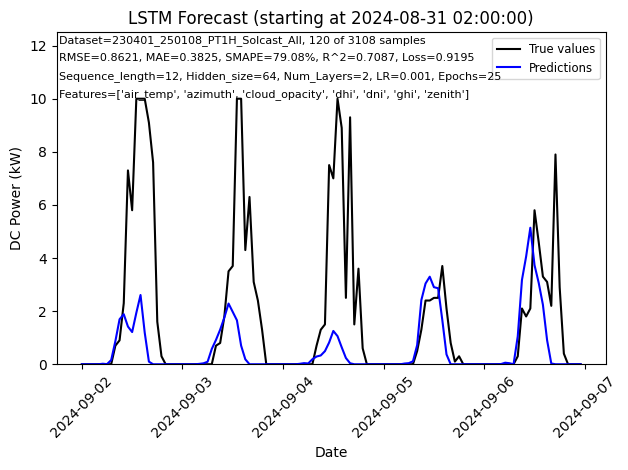

In [ ]:
# Step 12: Visualize predictions second plot
start_date = "2024-09-02"
nb_samples = 120 # 10 days if PT1H frequency

# Plot filtered data
plt.plot(data[start_date:]["dc_power"].iloc[:nb_samples], color="black", label="True values")
plt.plot(data[start_date:].iloc[:nb_samples].index, predictions[len(predictions)-len(data[start_date:].iloc[:nb_samples]):], color="blue", label="Predictions")
plt.legend(loc="upper right", fontsize="small")
plt.ylabel("DC Power (kW)")
plt.xlabel("Date")
plt.title(f"LSTM Forecast (starting at {TEST_DATA_START_DATETIME})")
plt.figtext(0.1, 0.9,f"Dataset={file_name_no_extension(FILEPATH)}, {nb_samples} of {len(X_test)} samples", fontsize=8, color='black')
plt.figtext(0.1, 0.8625,f"RMSE={RMSE:.4f}, MAE={MAE:.4f}, SMAPE={SMAPE:.2f}%, R^2={R2:.4f}, Loss={LOSS:.4f}", fontsize=8, color='black')
plt.figtext(0.1, 0.8250,f"Sequence_length={SEQUENCE_LENGTH}, Hidden_size={HIDDEN_SIZE}, Num_Layers={NUM_LAYERS}, LR={LR}, Epochs={NUM_EPOCHS}", fontsize=8, color='black')
plt.figtext(0.1, 0.7875,f"Features={features}", fontsize=8, color='black')

# Set y-axis limits
plt.ylim(0, 12.5)

# Set y-axis limits and x-axis formatting
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)

# Adjust layout and save plot
plt.tight_layout()
plt.savefig(f"LSTM-{start_date}-RMSE={RMSE:.4f}-SEQUENCE_L={SEQUENCE_LENGTH}.pdf")
plt.show()